In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
#%matplotlib inline

In [4]:
import sys

In [5]:
sys.path.insert(1, "/home/gemeinl/code/braindecode_lazy/")

In [6]:
from examples.utils import read_network_results, df_list_from_dir, dfs_from_dir

In [21]:
from itertools import product
import os
import pylab

def plot_result_overview(result_directory, decoding_tasks, models, metric_name,
                         fs=20, out_dir=None, data_format="pdf", ylim=(10, 25)):
    result_df = pd.DataFrame()
    splits = ["cv", "eval"]
    i = 0
    for model, decoding_task, decoding_type in product(
            models, decoding_tasks, splits):
        path = os.path.join(result_directory, model.lower(), decoding_task,
                            decoding_type) + "/"
        if os.path.exists(path):
            dfs = df_list_from_dir(path)
            assert len(dfs) == 5, (
                "expected 5 dataframes from 5 folds/repetitions")
            if "test_misclass" in dfs[0]:
                misclass_or_rmse = "misclass"
                factor = 100
            else:
                misclass_or_rmse = "rmse"
                factor = 1
            misclasses = [d["test_"+misclass_or_rmse].iloc[-1]
                          for d in dfs]
            for misclass in misclasses:
                result_df = result_df.append({
                    "model": model.lower(),
                    "subset": decoding_type,
                    "task": decoding_task,
                    "misclass/rmse": 100- misclass*factor},
                    ignore_index=True)
            i += 1

    # hack
    # rf cv and eval
    rf_cv_results = [100 * a for a in [0.836397,0.854512,0.848987,0.793738,0.821363]]
    for rf_cv_result in rf_cv_results:
        result_df = result_df.append({
            "model": "rf", "subset": "cv", "task": "pathological",
            "misclass/rmse": rf_cv_result}, ignore_index=True)
    rf_eval_results = [100 * a for a in [0.833333,0.847826,0.844203,0.840580,0.836957]]
    for rf_eval_result in rf_eval_results:
        result_df = result_df.append({
            "model": "rf", "subset": "eval", "task": "pathological",
            "misclass/rmse": rf_eval_result}, ignore_index=True)
    
    # asc cv and eval
    asc_eval_results = [100 * a for a in [
        0.8405797101449275, 0.8478260869565217, 0.8442028985507246, 
        0.8514492753623188, 0.8514492753623188]]
    for asc_eval_result in asc_eval_results:
        result_df = result_df.append({
            "model": "auto-sklearn", "subset": "eval", "task": "pathological",
            "misclass/rmse": asc_eval_result}, ignore_index=True)
    
    asc_cv_results = [100 * a for a in [
        0.852725, 0.85162, 0.849779, 0.853461, 0.851988]]
    #asc_cv_results = [100 * a for a in [0.852725]]#, 0.851620, 0.849779, 0.853461, 0.851988]]
    for asc_cv_result in asc_cv_results:
        result_df = result_df.append({
            "model": "auto-sklearn", "subset": "cv", "task": "pathological",
            "misclass/rmse": asc_cv_result}, ignore_index=True)
    
    # rg cv and eval
    rg_cv_results = [100 * a for a in [
        0.8106617647058824, 0.8139963167587477, 0.8139963167587477, 
        0.8139963167587477, 0.8103130755064457]]
    for rg_cv_result in rg_cv_results:
        result_df = result_df.append({
            "model": "rg", "subset": "cv", "task": "pathological",
            "misclass/rmse": rg_cv_result}, ignore_index=True)
    result_df = result_df.append({
        "model": "rg", "subset": "eval", "task": "pathological",
        "misclass/rmse": 100-14.13}, ignore_index=True)
    
    # svm cv and eval
    svm_cv_results = [100 * a for a in [
        0.8253676470588235, 0.8066298342541437, 0.8287292817679558,
        0.8084714548802947, 0.8103130755064457]]
    for svm_cv_result in svm_cv_results:
        result_df = result_df.append({
            "model": "svm", "subset": "cv", "task": "pathological",
            "misclass/rmse": svm_cv_result}, ignore_index=True)
    result_df = result_df.append({
        "model": "svm", "subset": "eval", "task": "pathological",
        "misclass/rmse": 100-19.2}, ignore_index=True)
    # hack end

    n_colors = len(decoding_tasks)*len(models)
    cm = pylab.get_cmap("Set1")
    # cm = pylab.get_cmap('tab10')
    # cm = pylab.get_cmap('viridis')
    # cm = pylab.get_cmap('tab20')
    random_width = .3
    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True,
                             figsize=(18, 5))
    for j, decoding_type in enumerate(splits):
        xticklabels = []
        ax = axes[j]
        title = "Cross-validation" if decoding_type == "cv" else "Final evaluation"
        ax.set_title(title, fontsize=fs)
        for i, (decoding_task, model) in enumerate(product(
                decoding_tasks, models)):
            d = result_df[(result_df.model == model.lower()) &
                          (result_df.task == decoding_task) &
                          (result_df.subset == decoding_type)]
            marker = "^" if j == 0 else "o"
            c = cm(1.*i/n_colors) if i < 5 else cm(1.*(i+1)/n_colors)
            if len(d) > 1:
                ax.scatter(np.random.rand(len(d))*random_width+i+.5+random_width,
                           d["misclass/rmse"],
                           color=c, label="", marker=marker)
            #c = cm(1.*i/n_colors) if i < 4 else cm(1.*(i+1)/n_colors)
            ax.scatter(np.array([i+1]), np.array([d["misclass/rmse"].mean()]),
                       marker=marker, color=c,
                       s=200, facecolor="none", label="{:.2f} ($\pm$ {:.2f})"
                       .format(d["misclass/rmse"].mean(),
                               d["misclass/rmse"].std()))
            model_name = "BD-"+model if model not in ["RF", "SVM", "RG", "auto-sklearn"] else model
            model_name = model_name+"4" if model_name == "BD-Deep" else model_name
            xticklabels.append('\n'.join([model_name if model_name != "auto-sklearn" else "ASC"]))

        ylabel = "accuracy [%]" #metric_name + " [%]"
        ax.set_yticks(np.linspace(0, 100, 21, dtype=int))
        ax.set_ylabel(ylabel, fontsize=fs)
        ax.tick_params(axis="y", labelsize=fs)
        ax.set_xlim(0, (len(xticklabels) + 1))
        ax.set_ylim(ylim)
        ax.legend(fontsize=fs-10, loc="upper center",
                  ncol=int(len(models)))#*len(decoding_tasks)/2))

    plt.xticks(np.arange(1, len(xticklabels) + 2),
               xticklabels, rotation=0, fontsize=fs)
    # plt.xlabel("experiment", fontsize=fs)

    if out_dir is not None:
        plt.savefig(out_dir+"result_overview.{}".format(data_format), bbox_inches="tight")
    return result_df

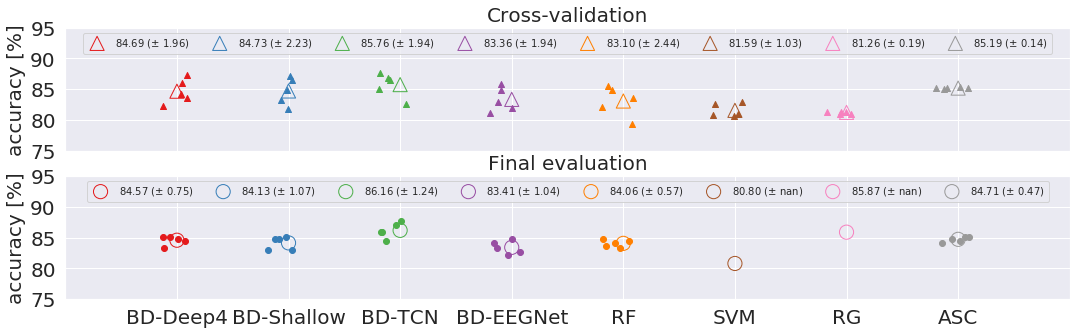

In [23]:
np.random.seed(13)
result_df = plot_result_overview("/home/gemeinl/results/all_recs_100_hz/networks/", 
                     ["pathological"],# "gender", "age"],#"gender_normal", "gender_abnormal", "age", "age_normal", "age_abnormal"], 
                     ["Deep", "Shallow", "TCN", "EEGNet", "RF", "SVM", "RG", "auto-sklearn"], "misclass", data_format="pdf",
                     ylim=(75,95),
                     #out_dir="/home/gemeinl/"
                    )